In [1]:
# ML Tools
import numpy as np 
import pandas as pd 
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# To prepare data
import re
from nltk.corpus import stopwords
from sklearn.utils import shuffle
# import nltk
# nltk.download('stopwords')
# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# Train Tools
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle

# other settings
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

2022-11-05 18:55:28.946502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Input Data

In [2]:
train = pd.read_csv('data/tweets.csv')
train = shuffle(train)
test = pd.read_csv('data/tweets_test.csv')
test = shuffle(test)

print("Train Data: ", train.shape)
display(train.head())
print("Test Data: ",  test.shape)
display(test.head())

Train Data:  (80000, 2)


,text,label
68505,"чем ближе новый год, тем больше планов накрыва...",1
43950,"@rotapost я не только про #Twitter, но и про и...",1
12147,"@artdor кто шарит в политологии,может проанали...",0
24421,Пытаюсь нажраться сиропом от кашля и новопасси...,0
48132,RT @qifubobonyz: Меня посетило преддрожное вол...,1


Test Data:  (16000, 2)


,text,label
3712,"RT @tezalypi: Поспорил давненько с друзьями, ч...",0
363,Некто как обычно не хочет гулять( опять буд...,0
4389,"Только обретешь немноо счастья, его тотчас же ...",0
6762,"Завтра утром обещают -27! Морозно, однако!(((",0
5833,Музыкальный ряд отменяется. И радостно и груст...,0


## 2. Data Preprocessing

In [3]:
for i, x in enumerate(train['text']):
    if len(train['text'][i]) < 50 or len(train['text'][i]) > 140:
        train['text'][i] = None
for i, x in enumerate(test['text']):
    if len(test['text'][i]) < 50 or len(test['text'][i]) > 140:
        test['text'][i] = None
        
train = train.dropna()
test = test.dropna()

y_test = test['label']

In [4]:
# clean data from punctuation marks and convert to lowercase

stopwords_rus = set(stopwords.words("russian"))

def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub("[^а-я]", " ", text)
    words = [word for word in text.split() if word not in stopwords_rus]
    text = " ".join(words)
    return text

clean_train_reviews = train['text'].map(clean_text)
clean_test_reviews = test['text'].map(clean_text)

## 3. Tokenization

In [5]:
# prepare data for training
MAX_SEQUENCE_LENGTH = 140

vocab_size = 152836

tokenizer = Tokenizer()

tokenizer.fit_on_texts(clean_train_reviews + clean_train_reviews)

text_sequences = tokenizer.texts_to_sequences(clean_train_reviews)
train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

text_sequences = tokenizer.texts_to_sequences(clean_test_reviews)
test_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

## 4. Build Model

In [6]:
def model_tweet():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 16, input_length=MAX_SEQUENCE_LENGTH))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.005)))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(8, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
    return model

## 5. Compile and Train

In [7]:
model = model_tweet()
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 16)           2445376   
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                        

2022-11-05 18:55:54.697832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
X_val = train_inputs[:4000]
X_train = train_inputs[4000:]

y_val = np.array(train['label'].iloc[:4000])
y_train = np.array(train['label'].iloc[4000:])

In [9]:
checkpoint_path = "pretrained_models/training_tweets/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)
history = model.fit(X_train,
                    y_train,
                    epochs=15,
                    batch_size=512,
                    validation_data=[X_val, y_val],
                    verbose=1,
                    callbacks=[cp_callback])

Epoch 1/15
135/135 [==============================] - 4s 25ms/step - loss: 0.7490 - acc: 0.5499 - val_loss: 0.7119 - val_acc: 0.5435
Epoch 2/15
135/135 [==============================] - 3s 23ms/step - loss: 0.6983 - acc: 0.5505 - val_loss: 0.6925 - val_acc: 0.5435
Epoch 3/15
135/135 [==============================] - 3s 22ms/step - loss: 0.6893 - acc: 0.5505 - val_loss: 0.6898 - val_acc: 0.5435
Epoch 4/15
135/135 [==============================] - 3s 21ms/step - loss: 0.6882 - acc: 0.5505 - val_loss: 0.6894 - val_acc: 0.5435
Epoch 5/15
135/135 [==============================] - 3s 23ms/step - loss: 0.6881 - acc: 0.5505 - val_loss: 0.6895 - val_acc: 0.5435
Epoch 6/15
135/135 [==============================] - 3s 21ms/step - loss: 0.6881 - acc: 0.5505 - val_loss: 0.6895 - val_acc: 0.5435
Epoch 7/15
135/135 [==============================] - 3s 22ms/step - loss: 0.6881 - acc: 0.5505 - val_loss: 0.6893 - val_acc: 0.5435
Epoch 8/15
135/135 [==============================] - 3s 22ms/step - 

## 6. Predict

In [12]:
checkpoint_path = "pretrained_models/training_tweets/cp.ckpt"
model.load_weights(checkpoint_path)

454/454 [==============================] - 0s 673us/step
0.702510691129811


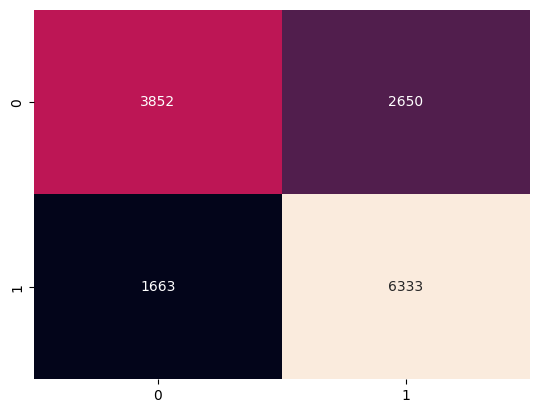

In [13]:
predictions = np.rint(model.predict(test_inputs)).astype('int32').squeeze()

cfm = confusion_matrix(y_test, predictions)
sns.heatmap(cfm, annot=True, fmt="d", cbar=False)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)